In [1]:
!pip install -Uqq fastai
!pip install -Uqq librosa

In [2]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
import re
import itertools
import matplotlib.pyplot as plot
sys.path.append('../')

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = Path("../Dataset/Dataset/IRMAS_Validation_Data/")
get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#2874) [Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-11.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-12.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-13.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-14.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-15.wav')]


In [4]:
path = Path("../Dataset/Dataset/IRMAS_Validation_Data/")
def file_labels(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
file_labels(song_path)

['gel', 'voi']

<class 'numpy.ndarray'> (513, 259)


Text(0, 0.5, 'Amplitude')

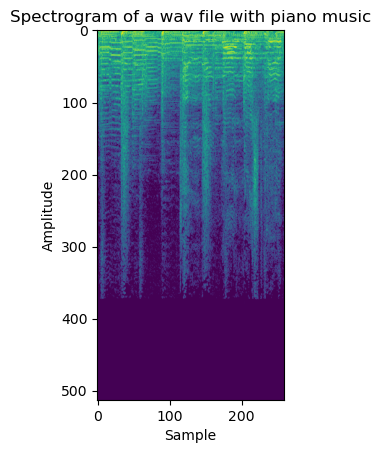

In [5]:
n_fft = 1024
hop_length = 512
f_min = 20
f_max = 8000
# sample_rate = 16000

def open_song(pat: Path):
    son = librosa.load(pat, sr=None) 
    return son

def song2spect(son):
    clip, sample_rate = son
    clip = clip[:sample_rate*3]
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, _ = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    return stft_magnitude_db
    
song = open_song(song_path)
spec = song2spect(song)
print(type(spec), spec.shape)
plot.title('Spectrogram of a wav file with piano music')
plot.imshow(spec)
plot.xlabel('Sample')
plot.ylabel('Amplitude')

In [6]:
def tfm(pat: Path):
    return song2spect(open_song(pat))

sdbl = DataBlock(
    blocks = [ImageBlock(), MultiCategoryBlock],
    get_items = get_song_files,
    item_tfms = tfm,
    splitter = RandomSplitter(),
    get_x = tfm,
    get_y = file_labels
)

In [7]:
dls = sdbl.dataloaders(path, bs=32)

In [8]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
dls.train

2300
574


['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']


32

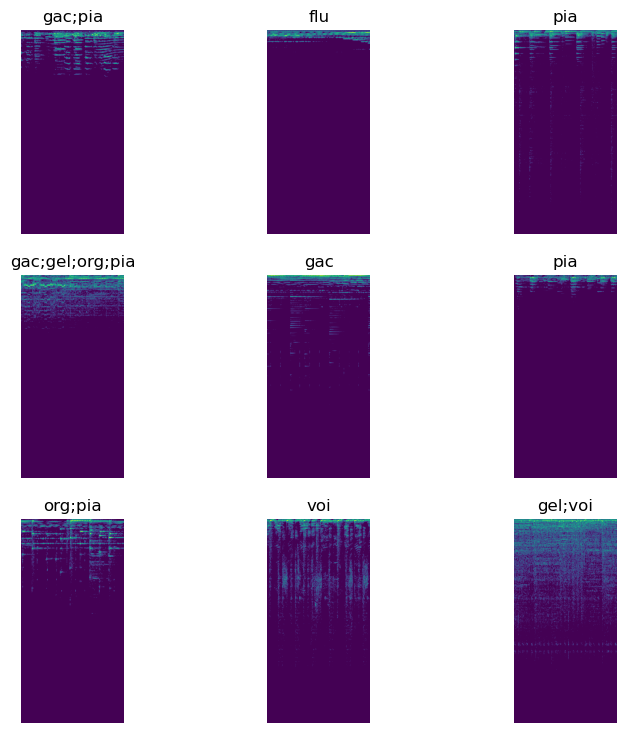

In [9]:
# sdbl.summary(path)
print(dls.vocab)
dls.train.show_batch()
dls.train.bs

In [10]:
learn = vision_learner(dls, resnet18, metrics=accuracy_multi)

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.837041,0.524817,0.750396,00:37


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.543729,0.347961,0.868863,00:39
1,0.380082,0.237214,0.913050,00:39
2,0.278666,0.224318,0.917327,00:39


In [13]:
# # interp = Interpretation.from_learner(learn)
# interp.plot_top_losses(30)

interp = ClassificationInterpretation.from_learner(learn)

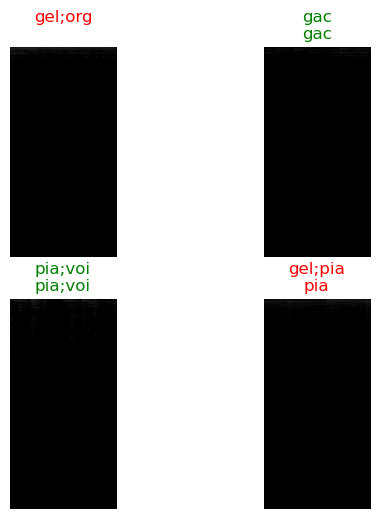

In [14]:
interp.show_results(list(range(4)))

,target,predicted,probabilities,loss
0,flu;gac;tru,,"TensorBase([0.0789, 0.0787, 0.0473, 0.0462, 0.4445, 0.1382, 0.2762, 0.0708,\n 0.0529, 0.0319, 0.1419])",0.9589629769325256
1,cel;flu;gac;voi,,"TensorBase([0.1510, 0.0259, 0.2673, 0.0676, 0.0502, 0.0255, 0.1771, 0.0499,\n 0.0301, 0.0357, 0.0410])",0.8650659322738647
2,flu;gel;pia;tru,pia;sax,"TensorBase([0.0186, 0.0170, 0.0717, 0.0408, 0.3894, 0.0723, 0.8466, 0.7006,\n 0.0262, 0.0170, 0.0229])",0.7987249493598938
3,gac,pia,"TensorBase([8.5092e-03, 4.0388e-03, 1.7593e-02, 1.4085e-02, 9.9884e-03,\n 9.9279e-03, 9.7538e-01, 9.4940e-02, 1.5718e-02, 9.1764e-03,\n 3.3817e-05])",0.7401759624481201
4,cla,pia,"TensorBase([0.0259, 0.1156, 0.0687, 0.0339, 0.0053, 0.0351, 0.9881, 0.3931,\n 0.1137, 0.4402, 0.0066])",0.7244128584861755
5,flu;gac;org;pia;voi,voi,"TensorBase([0.1689, 0.1597, 0.1035, 0.0947, 0.0833, 0.1700, 0.4075, 0.0302,\n 0.0563, 0.0529, 0.9946])",0.7172825932502747
6,flu;gel;pia;tru,gel,"TensorBase([0.0151, 0.0191, 0.0932, 0.1223, 0.9027, 0.2641, 0.2594, 0.3080,\n 0.0623, 0.0150, 0.0950])",0.686779797077179
7,pia,voi,"TensorBase([0.0175, 0.0537, 0.0961, 0.4035, 0.1193, 0.0948, 0.0378, 0.1105,\n 0.1319, 0.0480, 0.9455])",0.6737553477287292
8,cel;voi,,"TensorBase([0.0685, 0.0176, 0.0728, 0.0577, 0.3591, 0.0423, 0.1866, 0.0427,\n 0.0170, 0.0517, 0.0252])",0.6659526824951172
9,flu;gac;voi,gac,"TensorBase([0.2756, 0.0662, 0.2105, 0.7820, 0.0477, 0.0707, 0.0580, 0.0386,\n 0.0603, 0.1669, 0.0120])",0.6443508267402649


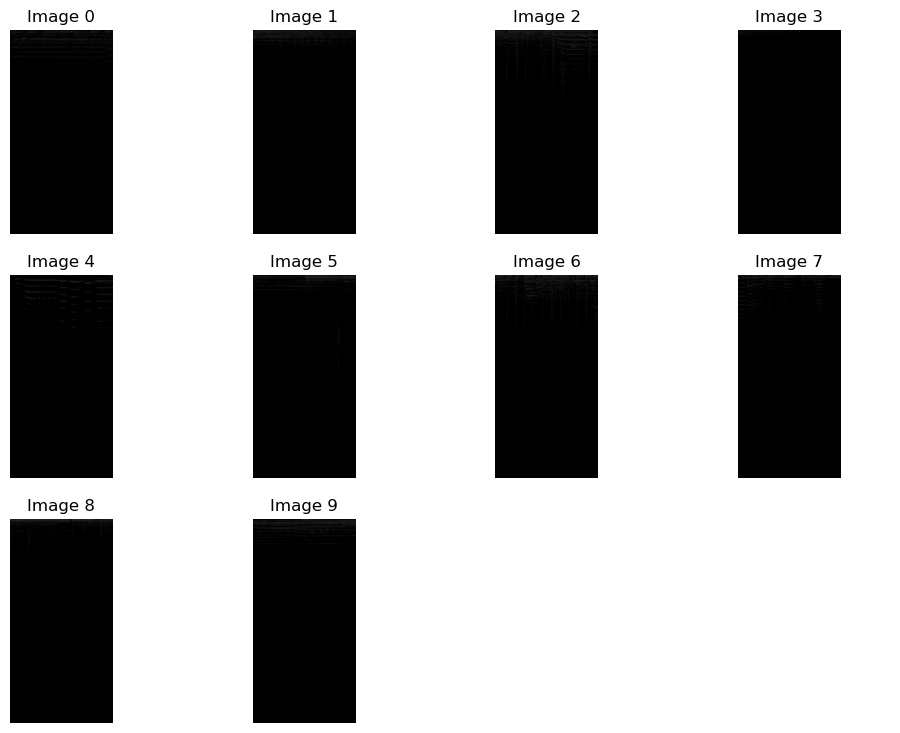

In [25]:
interp.plot_top_losses(10)